### readme:

主要作用：处理fits文件，保留J2000坐标信息，像素坐标信息，以及星系的物理参数
输出：.csv文件

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import h5py # used in the Data Visualization section

from astropy.io import fits,ascii,votable
from astropy import units as u
from astropy import constants as const
from astropy import table
from astropy.cosmology import Planck15,FlatLambdaCDM
from astropy.io import fits


# For ML application
from sklearn.cluster import KMeans
from sklearn import mixture
from itertools import combinations

import os

In [2]:
dir_out = './'


catversion = 'Classic'  # this string can be either 'Classic' or 'Farmer'
# Chose the SED fitting code:
# set to 'lp' for LePhare results or
# set to 'ez' for EAZY
fitversion = 'lp'

In [3]:
# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG'
flx = '_MAG_APER3'
flxerr = '_MAG_APER3ERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'cgs' # 'cgs' or 'uJy'

In [4]:
# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['GALEX_FUV', 'GALEX_NUV','CFHT_u','CFHT_ustar','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']
filt_lambda = [0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796]
# corresponding MW attenuation from Schelgel
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

In [5]:
# Upload the main catalogue
cat0 = table.Table.read('../COSMOS2020_CLASSIC_R1_v2.1_p3.fits',format='fits',hdu=1)

In [6]:
tem=fits.open('../COSMOS2020_CLASSIC_R1_v2.1_p3.fits')

In [27]:
tem[1].data

FITS_rec([(      1, 151.00853357, 1.39827825,  1304.95324707,  2579.13232422, 9.16915929e-06, 9.59818110e-06, -8.46130320e-07, nan, nan, 0, 1, 1, 1, 1, 0.02207518,  1.4749553e+01, 0.01090945,  2.2747913e+01, 0.01869604, 7.6082413e+01, 0.06277491, 20.978052, 8.0325606e-04, 20.507647, 8.9256105e-04, 19.196789, 8.9604879e-04, 19.228949, 9.0776995e-04,  3, 0,         nan,        nan,         nan,        nan,         nan,        nan,       nan,       nan,       nan,       nan,       nan,       nan,      nan,       nan, -99, -99,  97.51978, 0.12325739,  1.4058467e+02, 0.18836641,  3.8346591e+02, 0.18301807, 18.927267, 0.00137262, 18.530155, 0.00145511, 17.440683, 0.00051832, 17.46986 , 0.00052531,   3,   4, 229.9772  , 0.18475455,  3.3308636e+02, 0.28605017,  8.6636652e+02, 0.280283  , 17.995789, 0.00087245, 17.593607, 0.00093264, 16.555746, 0.00035134, 16.583054, 3.5562750e-04,   3,   4, 3.3389758e+02, 2.0034683e-01,  4.9036365e+02, 0.31173003,  1.2901099e+03, 0.29619917, 17.590967, 6.51626

In [28]:
# Create a mask to restrict the analysis to a subset of filters (optional)
filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']
filt_mask = [i in filt_use for i in filt_name]

### Flags (rows selection)

In [29]:
whichflag = 'HSC'  # try HSC, SUPCAM, UVISTA, UDEEP, COMBINED

print('The parent sample includes {} sources'.format(len(cat0)))
cat0 = cat0[cat0['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_{}'.format(len(cat0),whichflag))

The parent sample includes 1720700 sources
Now restricted to 1414142 sources by using FLAG_HSC


### Correcting for MW extinction

The following cell remove the foreground extinction by the Milky Way (MW).

以下单元格去除银河（MW）的前景消光。

In [30]:
def mw_corr(tab_in,f_dict,ebv_col='EBV_MW',flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """

    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if verbose: print('remove MW attenuation in ',c+flx_col,f_dict[c][2])
        if c not in skip_filt:
            atten = f_dict[c][2]*tab[ebv_col]
            if flux:    tab[c+flx_col] *= np.power(10.,0.4*atten)
            else:    tab[c+flx_col] -= atten
        else:
            if verbose: print('Skip filter',c)
    if out: return tab

In [31]:
# Here, the function creates a new table but
# it is also possible to overwrite the original table `cat0`
if catversion.lower()=='classic' and flx!='_FLUX' and flx!='_MAG':
    # it means you are using aperture or AUTO flux/mag, which are not available for IRAC and GALEX
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],out=True) # fluxes are  in uJy (zero point = 23.9)
    # therefore, IRAC and GALEX have to be taken into account separately:
    mw_corr(cat1,filt_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',only_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'])
else:
    # otherwise, all filters have the same suffix
    cat1 = mw_corr(cat0,filt_dict,flx_col=flx,flxerr_col=flxerr,only_filt=filt_use,out=True)  # all bands have same column suffix

### Correcting for aperture-to-total flux
纠正孔径与总通量的关系


Circular aperture flux, available only in the *Classic* catalog, can be converted to total flux using a rescaling factor derived for each source from its APER-to-AUTO ratio.

只有在*classic*目录中才有的圆形孔径通量，可以通过对每个源的APER-AUTO比率得出的重新调整系数转换为总通量。

In [34]:
def aper_to_tot(tab_in,f_dict,flx_col='_FLUX',flxerr_col='_FLUXERR',scale_col='',out_col=None,only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    scale_col : name of the `tab_in` column containing the aper-to-total correction
    out_col : if defined, the rescaled photometry will be saved in a new column (otherwise it overwrites `flx_col`)
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """

    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt
    for c in ff:
        if c not in skip_filt:

            if verbose and flux: print('rescale {} to total flux'.format(c+flx_col))
            if verbose and not flux: print('rescale {} to total mag'.format(c+flx_col))

            if flux:
                resc = np.power(10.,-0.4*tab[scale_col])
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] * resc
                    tab[c+out_col+'ERR'] = tab[c+flxerr_col] * resc  # rescale also error bars not to alter the S/N ratio
                else:
                    tab[c+flx_col] *= resc
                    tab[c+flxerr_col] *= resc
            else:
                if out_col:
                    tab[c+out_col] = tab[c+flx_col] + tab[scale_col]
                else:
                    tab[c+flx_col] += tab[scale_col]
        else:
            if verbose: print('Skip filter',c)
    if out: return tab

In [35]:
# Can be applied only to aperture photometry (not to AUTO or Farmer)
if (flx[-1]=='2' or flx[-1]=='3'):
    aper_to_tot(cat1,filt_dict,flx_col=flx,flxerr_col=flxerr,out_col='_FLUX',
    only_filt=filt_use,skip_filt=['IRAC_CH1', 'IRAC_CH2', 'GALEX_FUV', 'GALEX_NUV'],
    scale_col='total_off'+flx[-1],verbose=True)

rescale CFHT_ustar_MAG_APER3 to total mag
rescale CFHT_u_MAG_APER3 to total mag
rescale HSC_g_MAG_APER3 to total mag
rescale HSC_r_MAG_APER3 to total mag
rescale HSC_i_MAG_APER3 to total mag
rescale HSC_z_MAG_APER3 to total mag
rescale HSC_y_MAG_APER3 to total mag
rescale UVISTA_Y_MAG_APER3 to total mag
rescale UVISTA_J_MAG_APER3 to total mag
rescale UVISTA_H_MAG_APER3 to total mag
rescale UVISTA_Ks_MAG_APER3 to total mag
Skip filter IRAC_CH1
Skip filter IRAC_CH2


### Correcting for photometric offset

These are the systematic offsets in flux found by either `LePhare` or `EAZY` by using the COSMOS spectroscopic sample. They depend on the photometry (rescaled aperture-to-total photometry *Classic*, or the total photometry in *Farmer*) and on the SED fitting code (*LePhare* or *EAZY*). This correction has not been calculated for the AUTO fluxes in *Classic*. In the following we consider *LePhare* as a reference, whose prefix in the catalogue is `lp_` (e.g., `lp_zBEST`). *EAZY* prefix is `ez_`.

纠正测光偏移
这些是LePhare或EAZY通过使用COSMOS的光谱样本发现的通量的系统性偏移。它们取决于光度测量（重新调整过的孔径与总光度测量的经典版，或Farmer的总光度测量）和SED拟合代码（LePhare或EAZY）。这种修正没有为经典版中的AUTO通量进行计算。在下文中，我们将LePhare作为参考，它在目录中的前缀是lp_（例如，lp_zBEST）。EAZY的前缀是ez_。

In [36]:
def photo_corr(tab_in,f_dict,versions=('Farmer','lp'),flx_col='_FLUX',only_filt=[],skip_filt=[],verbose=False,out=False):
    """
    Parameters
    ----------
    tab_in : astropy table of COSMOS2020
    f_dict : dictionary with filter info
    ebv_col : name of the `tab_in` column containing the E(B-V) from Milky Way
    flx_col : name of the `tab_in` column containing the flux
    flxerr_col : name of the `tab_in` column containing the flux error bar
    only_filt : list of the filters to be processed (filter names as in `f_dict`)
    skip_filt : list of the filters NOT to be processed (filter names as in `f_dict`)
    verbose : if True, print a verbose output
    out : if True, return a new table with the changes; if False, overwrite `tab_in`
    """
    if 'FLUX' in flx_col: flux=True
    else: flux=False
    if out: tab = tab_in.copy()
    else: tab = tab_in
    ff = f_dict.keys()
    if len(only_filt)>0 : ff = only_filt

    if versions[0]=='Farmer' and versions[1]=='lp': v=0
    elif versions[0]=='Farmer' and versions[1]=='ez': v=1
    elif versions[0]=='Classic' and versions[1]=='lp': v=2
    elif versions[0]=='Classic' and versions[1]=='ez': v=3
    else:
        print("ERROR: is this catalog version real?", version)
        return

    for c in ff:
        if verbose: print(' apply photometric offset to ',c+flx_col)
        offset = f_dict[c][3][v]
        if c not in skip_filt and offset!=0.:
            if flux:  tab[c+flx_col] *= np.power(10.,-0.4*offset)
            else:  tab[c+flx_col] += offset
        else:
            if verbose: print('Skip filter',c)
    if out: return tab

In [37]:
photo_corr(cat1,filt_dict,only_filt=filt_use,versions=(catversion,fitversion))

### Final formatting

Define a new astropy table `cat` which will be used in the rest of this Notebook.

Before saving the new table, remove from the catalogue the columns that are not used. Also convert flux units, and add AB magnitudes.

定义一个新的天体表`cat`，它将在本笔记本的其余部分中使用。

在保存新表之前，从目录中删除那些不使用的列。同时转换通量单位，并添加AB级。

In [41]:
cat = cat1.copy()

In [42]:
print(cat1.info)

<Table length=1414142>
           name             dtype        unit        format     class      n_bad 
-------------------------- ------- ---------------- -------- ------------ -------
                        ID   int64                                 Column       0
               ALPHA_J2000 float64              deg                Column       0
               DELTA_J2000 float64              deg                Column       0
                   X_IMAGE float64              pix                Column       0
                   Y_IMAGE float64              pix                Column       0
               ERRX2_IMAGE float64             pix2                Column       0
               ERRY2_IMAGE float64             pix2                Column       0
               ERRXY_IMAGE float64             pix2                Column       0
               FLUX_RADIUS float32              pix          MaskedColumn  624034
               KRON_RADIUS float32                           MaskedColumn  

In [43]:
cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000','X_IMAGE','Y_IMAGE']+
                 [i+'_FLUX' for i in filt_use]+
                 [i+'_MAG_APER3' for i in ['HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y']]+
                 [i+'_MAGERR_APER3' for i in ['HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y']]+
                 [i+'_FLUXERR_APER3' for i in ['HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y']]+
                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+
                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_mass_best','lp_sSFR_best'])
'''
cat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+
                 [i+'_FLUX' for i in filt_use]+
                 [i+'_FLUXERR' for i in filt_use]+
                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+
                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_sSFR_med','lp_mass_best'])
'''

# filt_use = ['CFHT_ustar', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2']

"\ncat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+\n                 [i+'_FLUX' for i in filt_use]+\n                 [i+'_FLUXERR' for i in filt_use]+\n                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+\n                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_sSFR_med','lp_mass_best'])\n"

"\ncat.keep_columns(['ID','ALPHA_J2000','DELTA_J2000']+\n                 [i+'_FLUX' for i in filt_use]+\n                 [i+'_FLUXERR' for i in filt_use]+\n                 ['lp_zBEST','lp_model','lp_age','lp_dust','lp_Attenuation','lp_zp_2','lp_zq','lp_type']+\n                 ['lp_MNUV','lp_MR','lp_MJ','lp_mass_med','lp_mass_med_min68','lp_mass_med_max68','lp_SFR_med','lp_sSFR_med','lp_mass_best'])\n"

In [44]:
'''
# optional: magnitudes in AB system
m0 = +23.9  # fluxes in the catalog are in microJansky
for b in filt_use:
    mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0  # log of negative flux is masked
    cat.add_column(mag.filled(np.nan),name=b+'_MAG')  # negative flux becomes NaN
'''

"\n# optional: magnitudes in AB system\nm0 = +23.9  # fluxes in the catalog are in microJansky\nfor b in filt_use:\n    mag = -2.5*np.log10(cat[b+'_FLUX'].data) + m0  # log of negative flux is masked\n    cat.add_column(mag.filled(np.nan),name=b+'_MAG')  # negative flux becomes NaN\n"

In [45]:
# flux conversion from uJy to erg/cm2/s/Hz
if outflx=='cgs':
    for b in filt_use:
        cat[b+'_FLUX'] *= 1e-29
        cat[b+'_FLUX'].unit = u.erg/u.cm/u.cm/u.s/u.Hz
        # cat[b+'_FLUXERR'] *= 1e-29
        # cat[b+'_FLUXERR'].unit = u.erg/u.cm/u.cm/u.s/u.Hz

One may want to **rename some columns** in a more user-friendly fashion. For example, the reference photo-z estimates (the ones to use in most of the cases) are originally named `lp_zBEST` for *LePhare* and `ez_z_phot` for *EAZY*. Once chosen the version, it is convenient to change the correspondent column to a standard name (e.g., `photoz`) so that the rest of the Notebook will work either way.

人们可能想以一种更方便用户的方式重新命名一些列。例如，参考的photo-z估计值（在大多数情况下要使用的）最初在LePhare中被命名为lp_zBEST，在EAZY中被命名为ez_z_phot。一旦选择了版本，就可以方便地将相应的列改为标准名称（如photoz），这样笔记本的其他部分就可以以任何方式工作。

In [46]:
cat.rename_column('lp_zBEST', 'photoz')
cat.rename_column('ALPHA_J2000','RA')
cat.rename_column('DELTA_J2000','DEC')

In [47]:
# Save the re-formatted table as a FITS file.

# cat.write(dir_out+'COSMOS2020_{}_processed.fits'.format(catversion),overwrite=True)

cat_galaxies=cat[cat['lp_type']==0]
# cat_galaxies.write(dir_out+'COSMOS2020_{}_lp_type_0_galaxies.fits'.format(catversion),overwrite=True)

In [48]:
cat.info

<Table length=1414142>
        name         dtype        unit          class     n_bad 
------------------- ------- ---------------- ------------ ------
                 ID   int64                        Column      0
                 RA float64              deg       Column      0
                DEC float64              deg       Column      0
            X_IMAGE float64              pix       Column      0
            Y_IMAGE float64              pix       Column      0
HSC_g_FLUXERR_APER3 float32              uJy MaskedColumn     92
    HSC_g_MAG_APER3 float32              mag MaskedColumn  30684
 HSC_g_MAGERR_APER3 float32              mag MaskedColumn  30684
HSC_r_FLUXERR_APER3 float32              uJy MaskedColumn     92
    HSC_r_MAG_APER3 float32              mag MaskedColumn  10793
 HSC_r_MAGERR_APER3 float32              mag MaskedColumn  10793
HSC_i_FLUXERR_APER3 float32              uJy MaskedColumn     92
    HSC_i_MAG_APER3 float32              mag MaskedColumn   3402
 H

-----------------------
## Visualization of the catalogue's main features

In [29]:
nsrc = len(cat)
print('This catalogue has',nsrc,'sources: ')
print(' - unreliable/corrupted ones = ',np.count_nonzero(cat['lp_type']<0.))
print(' - photometric stars = ',np.count_nonzero(cat['lp_type']==1))
print(' - photometric galaxies = ',np.count_nonzero(cat['lp_type']==0))
print(' -- plus other {} objects that are classified as X-ray AGN'.format(np.count_nonzero(cat['lp_type']==2)))
print('\nThis catalogue has',len(cat.columns),'columns')
zmin = min(cat['photoz'][cat['photoz']>0.])
zmax = max(cat['photoz'][cat['photoz']<99.])
print('Redshift range {:.2f}<zphot<{:.2f}'.format(zmin,zmax))
ramin = min(cat['RA']); ramax = max(cat['RA'])
decmin = min(cat['DEC']); decmax = max(cat['DEC'])
print('Area covered [deg]: {:.6f}<RA<{:.6f} & {:.6f}<Dec<{:.6f}'.format(ramin,ramax,decmin,decmax))

This catalogue has 1414142 sources: 
 - unreliable/corrupted ones =  3210
 - photometric stars =  25253
 - photometric galaxies =  1382881
 -- plus other 2798 objects that are classified as X-ray AGN

This catalogue has 49 columns
Redshift range 0.01<zphot<9.98
Area covered [deg]: 149.057559<RA<151.063840 & 1.391497<Dec<3.071577


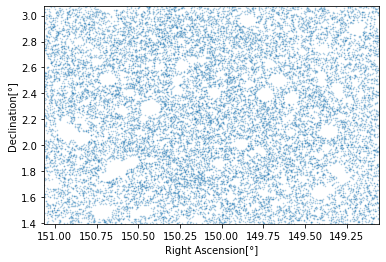

In [30]:
# Select a random subsample for sake of clarity
a = np.random.randint(0,nsrc,size=20000)
plt.scatter(cat['RA'][a],cat['DEC'][a],s=0.4,alpha=0.3)
plt.xlim(ramax,ramin)
plt.ylim(decmin,decmax)
plt.xlabel('Right Ascension[°]')
plt.ylabel('Declination[°]')
plt.show()

Redshift distributions and GzK diagram.
`lp_zp_2` is the secondary photoz solution in LePhare.
`lp_zq` is the photoz solution in LePhare using QSO/AGN templates.

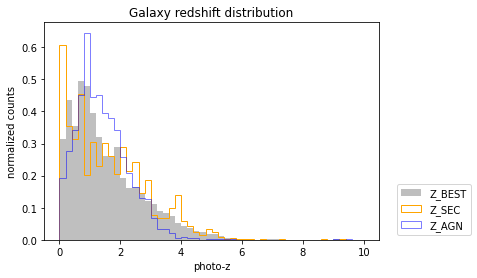

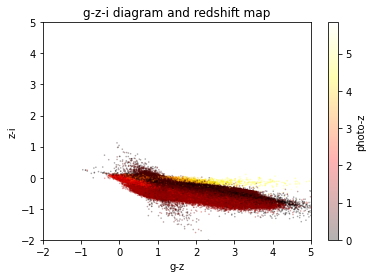

In [31]:
plt.hist(cat['photoz'],range=(0.01,10),log=False,bins=50,density=True,color ='grey',alpha=0.5,label = 'Z_BEST')
plt.hist(cat['lp_zp_2'],range=(0.01,10),log=False,bins=50,density=True,color ='orange',histtype='step',label = 'Z_SEC')
plt.hist(cat['lp_zq'][cat['lp_type']==2],range=(0.01,10),log=False,bins=50,density=True,color ='blue',alpha=0.5,label = 'Z_AGN',histtype='step')
plt.title('Galaxy redshift distribution')
plt.xlabel('photo-z')
plt.ylabel('normalized counts')
plt.legend(bbox_to_anchor=(1.04,0),loc='lower left')
plt.show()






color1 = cat['HSC_g_MAG_APER3'] - cat['HSC_z_MAG_APER3']
color2 = cat['HSC_z_MAG_APER3'] - cat['HSC_i_MAG_APER3']
zmap = cat['photoz']
sel = (cat['photoz']>=0.) & (cat['photoz']<6.) & (cat['HSC_z_MAG_APER3']<24.5)
plt.scatter(color1[sel],color2[sel],c=zmap[sel],cmap='hot',s=0.4,alpha=0.3)
plt.xlim(-2,5)
plt.ylim(-2,5)
cbar=plt.colorbar()
cbar.set_label('photo-z')
plt.xlabel('g-z')
plt.ylabel('z-i')

plt.title('g-z-i diagram and redshift map')
plt.show()

Show the galaxy models from Bruzual & Charlot (2003) that have been used in *LePhare* to measure physical quantities. These are the basic (dust-free) templates in the rest-frame reference system, stored in an acillary file with HDF5 format. The instrinsic models are modified a-posteriori by adding redshift, dust attenuation, intervening IGM absorption.

**Structure of the HDF5 file:** each BC03 model is a dataset (`/model1`,`/model2`, etc.) with a list of spectra (e.g., `/model1/spectra`) defined at the wavelength points stored in the attribute `lambda[AA]`. The number of spectra correspond to the number of ages stored in the attribute 'age' for each model dataset.

显示来自Bruzual & Charlot (2003)的星系模型，这些模型在*LePhare*中被用来测量物理量。这些是静止帧参考系统中的基本（无尘）模板，存储在一个HDF5格式的acillary文件中。本征模型通过添加红移、尘埃衰减、介入的IGM吸收而被事后修改。

**HDF5文件的结构：**每个BC03模型是一个数据集（`/model1',`/model2',等等），有一个光谱列表（例如`/model1/spectra'），定义在属性`lambda[AA]'中储存的波长点。光谱的数量对应于每个模型数据集的属性 "age "中存储的年龄数量。

In [35]:
hdf = h5py.File("../pycharm_projects/COSMOS2020_LePhare_v2_20210507_LIB_COMB.hdf5","r")

In [36]:
def model_check(models,wvl,labels,title='SED templates (rest frame)'):

    """
    This function plots the SEDs (F_lambda vs lambda and F_nu vs lambda)
    of the models specified by the user.
    这个函数绘制了用户指定的模型的SEDs（F_lambda vs lambda和F_nu vs lambda）。的模型。
    """
    # from a matplotlib colormap, create RGB colors for the figure
    cm = plt.get_cmap('gist_rainbow')
    cc = [cm(1.*i/len(labels)) for i in range(len(labels))]

    for i,f_lam in enumerate(models):
        plt.plot(wvl,f_lam,color=cc[i],label=labels[i]) # This will plot the flux lambda
    plt.legend(bbox_to_anchor=(1.04,0),loc='lower left',ncol=3)
    plt.title(title)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(800.,50000.) # focus on wvl range from UV to mid-IR
    plt.ylim(1e-14,1e-7)
    plt.xlabel('wavelength [Å]')
    plt.ylabel('Flux [erg/cm^2/s/Å]')
    plt.show()

    wvl *= u.AA # add units to ease conversion
    for i,f_lam in enumerate(models):
        f_lam *= u.erg/u.cm/u.cm/u.s/u.AA
        f_nu = f_lam*(wvl**2)/const.c
        f_nu = f_nu.to(u.erg/u.cm/u.cm/u.s/u.Hz)
        plt.plot(wvl,f_nu,color=cc[i],label=labels[i])
    plt.legend(bbox_to_anchor=(1.04,0),loc='lower left',ncol=3)
    plt.title(title)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(800.,50000.)
    plt.ylim(1e-26,1e-18)
    plt.xlabel('wavelength [Å]')
    plt.ylabel('Flux [erg/cm^2/s/Hz]')
    plt.savefig('bc03.png',dpi=300)
    plt.show()

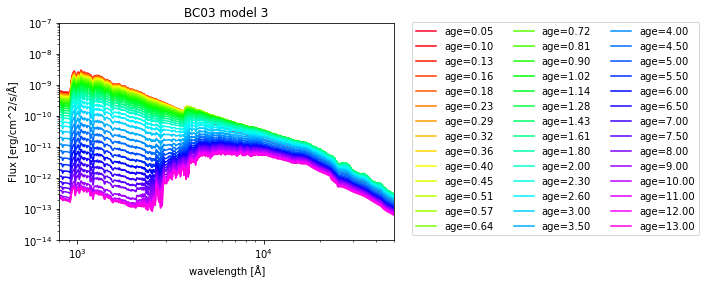

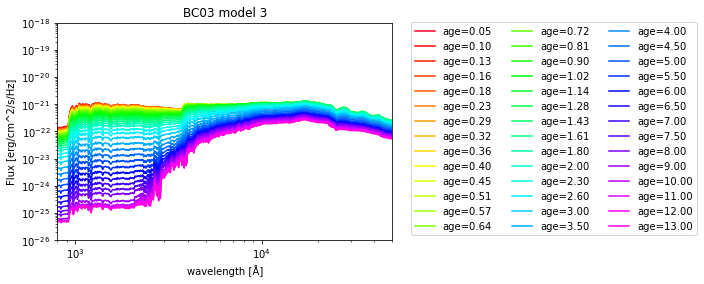

In [37]:
nmod = 3 # which model
model_check(hdf['/model{}/spectra'.format(nmod)],hdf['/model{}/spectra'.format(nmod)].attrs['lambda[AA]'],
            ['age={:.2f}'.format(i/1e9) for i in hdf['/model{}'.format(nmod)].attrs['age']],
           title='BC03 model {}'.format(nmod))

Show the observed SED of a given object, and overplot its BC03 template (after flux rescaling and dust attenuation). The template is the one resulting in the best fit (smallest $\chi^2$) according to *LePhare*. The SED fitting code takes also into account the absorption of intervening ISM and the flux contamination by strong nebular emission lines. However, for sake of simplicity, those two elements are not included here in the Notebook.

To visualize *EAZY* templates, a different python script is available upon request to Gabriel Brammer ([contacts](https://gbrammer.github.io/))

显示一个给定物体的观测SED，并重绘其BC03模板（在重新调整通量和尘埃衰减后）。模板是根据*LePhare*得出的最佳拟合（最小的$chi/^2$）。SED拟合代码还考虑到了中间的ISM的吸收和强星云发射线的流量污染。然而，为了简单起见，这两个因素在这里不包括在笔记本中。

为了使*EAZY*模板可视化，可以向Gabriel Brammer（[联系人](https://gbrammer.github.io/)）索取一个不同的python脚本。

In [38]:
# 计算发光距离
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
# note that COSMOS2020 SED fitting assumes 'vanilla' cosmology

In [39]:
def dust_ext(w,law=0,ebv=0.):

    law1 = np.loadtxt("SB_calzetti.dat").T
    law2 = np.loadtxt("extlaw_0.9.dat").T
    ext_w = [law1[0],law2[0]]
    ext_k = [law1[1],law2[1]]
    if ebv>0.:
        k = np.interp(w,ext_w[law],ext_k[law])
        return np.power(10.,-0.4*ebv*k)
    else:
        return 1.

In [40]:
id_gal = 354321 # the ID number of the galaxy you want to plot; IDs are different for Farmer and Classic
nid = np.where(cat['ID']==id_gal)[0][0]

wl_obs = np.array([filt_dict[i][0] for i in filt_use])  # wavelength center of the filter used
wl_obserr = np.array([filt_dict[i][1] for i in filt_use])/2.
fnu_obs = np.array([cat[i+'_FLUX'][nid] for i in filt_use]) # Reads the measured magnitude at that wavelength
fnu_obserr = np.array([cat[i+'_FLUXERR'][nid] for i in filt_use]) #Magnitude associated +/-error
sel = fnu_obs>0.
if cat['{}_FLUX'.format(filt_use[0])].unit.to_string()=='uJy':
    plt.ylabel('Flux [$\mu$Jy]')
    plt.errorbar(wl_obs[sel],fnu_obs[sel],xerr=wl_obserr[sel],yerr=fnu_obserr[sel],fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
    ymin = min(fnu_obs[sel])*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*6
else: # assuming it's cgs
    plt.ylabel('Flux [$10^{-29}$ erg/cm$^2$/s/Hz]')
    plt.errorbar(wl_obs[sel],fnu_obs[sel]*1e29,xerr=wl_obserr[sel],yerr=fnu_obserr[sel]*1e29,fmt='.k', ecolor = 'k', capsize=3, elinewidth=1,zorder=2)
    ymin = min(fnu_obs[sel])*1e29*0.5
    ymax = max(fnu_obs[sel]+fnu_obserr[sel])*1e29*6

# Using the redshift of best-fit template
zp = cat['photoz'][nid]
m = int(cat['lp_model'][nid])
wvl = hdf['/model{}/spectra'.format(m)].attrs['lambda[AA]'] *u.AA
t = np.abs(hdf['/model{}'.format(m)].attrs['age']-cat['lp_age'][nid]).argmin()
flam_mod = hdf['/model{}/spectra'.format(m)][t,:] *u.erg/u.cm/u.cm/u.s/u.AA
fnu_mod = flam_mod*(wvl**2)/const.c
# Calculates the flux in units of [uJy] also applying dust ext
fnu_mod = fnu_mod.to(u.erg/u.cm/u.cm/u.s/u.Hz) * dust_ext(wvl.value,law=cat['lp_Attenuation'][nid],ebv=cat['lp_dust'][nid])
# Rescale the template
mscal = hdf['/model{}'.format(m)].attrs['mass'][t]/10**cat['lp_mass_best'][nid]  # luminosity/mass resc
dm = cosmo.luminosity_distance(zp)/(10*u.pc)  # distance modulus
offset = dm.decompose()**2*mscal/(1+zp) # all together * (1+z) factor
# Plot the best-fit model
plt.plot(wvl*(1+zp),fnu_mod.to(u.uJy).value/offset,color='red',alpha=1,label='model',zorder=1)

# Show where nebular emission lines would potentially boost the flux
plt.vlines(3727*(1+zp),ymin,ymax,label='[OII]',zorder=0,color='0.3',ls=':')
plt.vlines(5007*(1+zp),ymin,ymax,label='[OIII]b',zorder=0,color='0.3',ls=':')
plt.vlines(4861*(1+zp),ymin,ymax,label='Hb',zorder=0,color='0.3',ls=':') # H_beta
plt.vlines(6563*(1+zp),ymin,ymax,label='Ha',zorder=0,color='0.3',ls=':') # H_alpha


plt.xscale('log')
plt.yscale('log')
plt.xlim(1000,100000)
plt.ylim(ymin,ymax)
plt.xlabel('wavelength [Å]')


print("The COSMOS fitted model is model number",m)
print('The offset applied is',offset,'and a redshift of',zp)
plt.show()

C:\Users\LiYibo\AppData\Local\Temp\ipykernel_12440\1807506041.py:6: UserWarning: Warning: converting a masked element to nan.
  fnu_obs = np.array([cat[i+'_FLUX'][nid] for i in filt_use]) # Reads the measured magnitude at that wavelength


KeyError: 'CFHT_ustar_FLUXERR'

----------------------------
## Classic diagnostics

Also useful to learn what columns contain the galaxy physical quantities.
Columns for the *LePhare* version:
- Absolute magnitudes have the `lp_M` prefix followed by the filter name in capital letters (e.g., `lp_MI` for the *i* band).
- The most reliable stellar mass estimate is `lp_mass_med`, since it's the median of the PDF$(M_\ast)$; `lp_mass_best` is the $M_\ast$ of the best-fit template which is actually not the best to use.
- Simliarly to $M_\ast$, also the other physical quantities should be used in their `lp_{}_med` version (e.g., `lp_SFR_med`)

**WARNING:** the SFR estimates included in the COSMOS2020 catalogs have not been thoroughly tested, and are not recommended for high-level scientific projects. Nonetheless, they can be useful for sanity checks like in this case.

经典诊断法

了解哪些列包含银河系的物理量也很有用。
栏目为*LePhare*版本。
- 绝对星等的前缀是`lp_M`，后面是大写的过滤器名称（例如，*i*波段的`lp_MI`）。
- 最可靠的恒星质量估计值是`lp_mass_med`，因为它是PDF$(M_\ast)$的中位数；`lp_mass_best`是最佳拟合模板的$M_ast$，实际上并不是最好用的。
- 与$M_ast$类似，其他物理量也应使用它们的`lp_{}_med`版本（例如，`lp_SFR_med`）。

**警告：**COSMOS2020目录中包含的SFR估计值还没有经过彻底的测试，不建议用于高级科学项目。尽管如此，它们对于像这种情况下的理智检查还是很有用的。

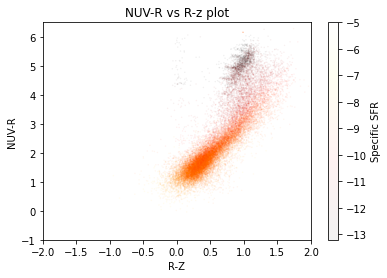

In [41]:
# Plot the NUV-r vs r-J diagram in a given z bin

zlow=0.5
zupp=0.8

# Cut the K magnitude at K<24 to remove noisy galaxies and stellar sequence
sel = (cat['HSC_z_MAG_APER3']<24) & (cat['photoz']<zupp) & (cat['photoz']>zlow) & (cat['lp_mass_med']>7)
catselec=cat[sel]

plt.scatter(catselec['lp_MR']-catselec['lp_MJ'],catselec['lp_MNUV']-catselec['lp_MR'],c=catselec['lp_SFR_med']-catselec['lp_mass_med'],s=0.3,alpha=0.05,cmap='hot',vmin=-12)
plt.clim(-5,-12)
clb = plt.colorbar()
clb.set_label('Specific SFR')
plt.ylim(-1,6.5)
plt.xlim(-2,2)
plt.xlabel('R-Z')
plt.ylabel('NUV-R')
plt.title('NUV-R vs R-z plot')
plt.show()

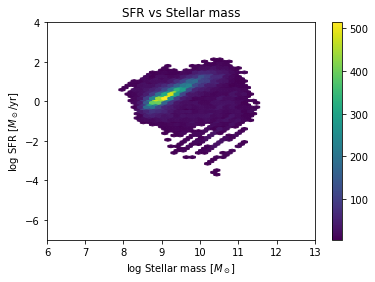

In [42]:
# Plot the SFR vs stellar mass diagram
# WARNING: the SFR estimates from SED fitting without far-IR data (as in this case) are not particularly reliable, use them with caution
# 警告：在没有远红外数据的情况下，从SED拟合得出的SFR估计值不是特别可靠，要谨慎使用。
plt.hexbin(catselec['lp_mass_med'],catselec['lp_SFR_med'],gridsize=(50,50),extent=(5,13,-7,4),mincnt=5)
plt.ylim(-7,4)
plt.xlim(6,13)
plt.title('SFR vs Stellar mass')
plt.ylabel('log SFR [$M_\odot$/yr]')
plt.xlabel('log Stellar mass [$M_\odot$]')
plt.colorbar()
plt.show()

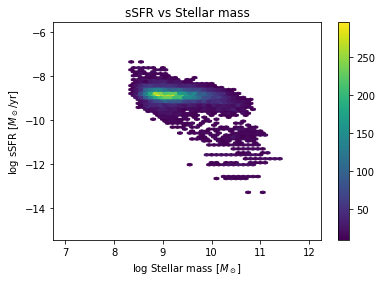

In [43]:
plt.hexbin(catselec['lp_mass_med'],np.array(catselec['lp_SFR_med']-catselec['lp_mass_med']),gridsize=(50,50),extent=(7,12,-15,-6),mincnt=10)
#plt.hexbin(catselec['lp_mass_med'],np.array(catselec['lp_SFR_med']-catselec['lp_mass_med']),gridsize=(50,50),extent=(5,13,-7,4),mincnt=5)
plt.title('sSFR vs Stellar mass')
plt.ylabel('log sSFR [$M_\odot$/yr]')
plt.xlabel('log Stellar mass [$M_\odot$]')
plt.colorbar()
plt.show()

In [60]:
arr=np.array(cat_galaxies)
data=pd.DataFrame(arr).iloc[:,:]
# data.to_csv('cat_galaxies.csv',index=False)

In [65]:
ttt=data.iloc[1000:2000]